<a href="https://colab.research.google.com/github/thinhngo-x/deep-learning/blob/master/TD5_ConvNets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
from torch import nn

from skimage import data
import torch
from torchvision import datasets, transforms
from torch.utils import data as torch_data
from tqdm.notebook import tqdm

## 1. Pooling

In [0]:
matplotlib.rcParams['font.size'] = 18

names = ['astronaut',
          'binary_blobs',
          'camera',
          'checkerboard',
          'chelsea',
          'clock',
          'coffee',
          'coins',
          'horse',
          'logo',
          'page',
          'text',
          'rocket']

images = {}
for name in names:
    caller = getattr(data, name)
    image = caller()
    images[name] = torch.Tensor(image.copy().T).type(torch.float) /255
    if(images[name].dim() < 3):
      h,w = images[name].shape
      images[name] = images[name].view(1, h, w)
      #print(images[name].shape)

<class 'torch.Tensor'>
torch.Size([3, 512, 512])


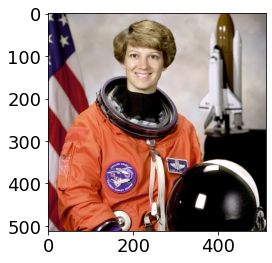

In [0]:
plt.imshow(images['astronaut'].T)
#print(images['astronaut'])
print(type(images['astronaut']))
print(images['astronaut'].shape)

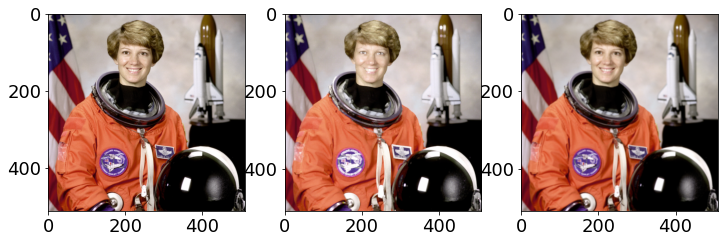

In [0]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,60))

ax[0].imshow(images['astronaut'].T)
max_pool = torch.nn.MaxPool2d(3, stride=1)(images['astronaut'])
ax[1].imshow(max_pool.T)
avg_pool = torch.nn.AvgPool2d(3, stride=1)(images['astronaut'])
ax[2].imshow(avg_pool.T)

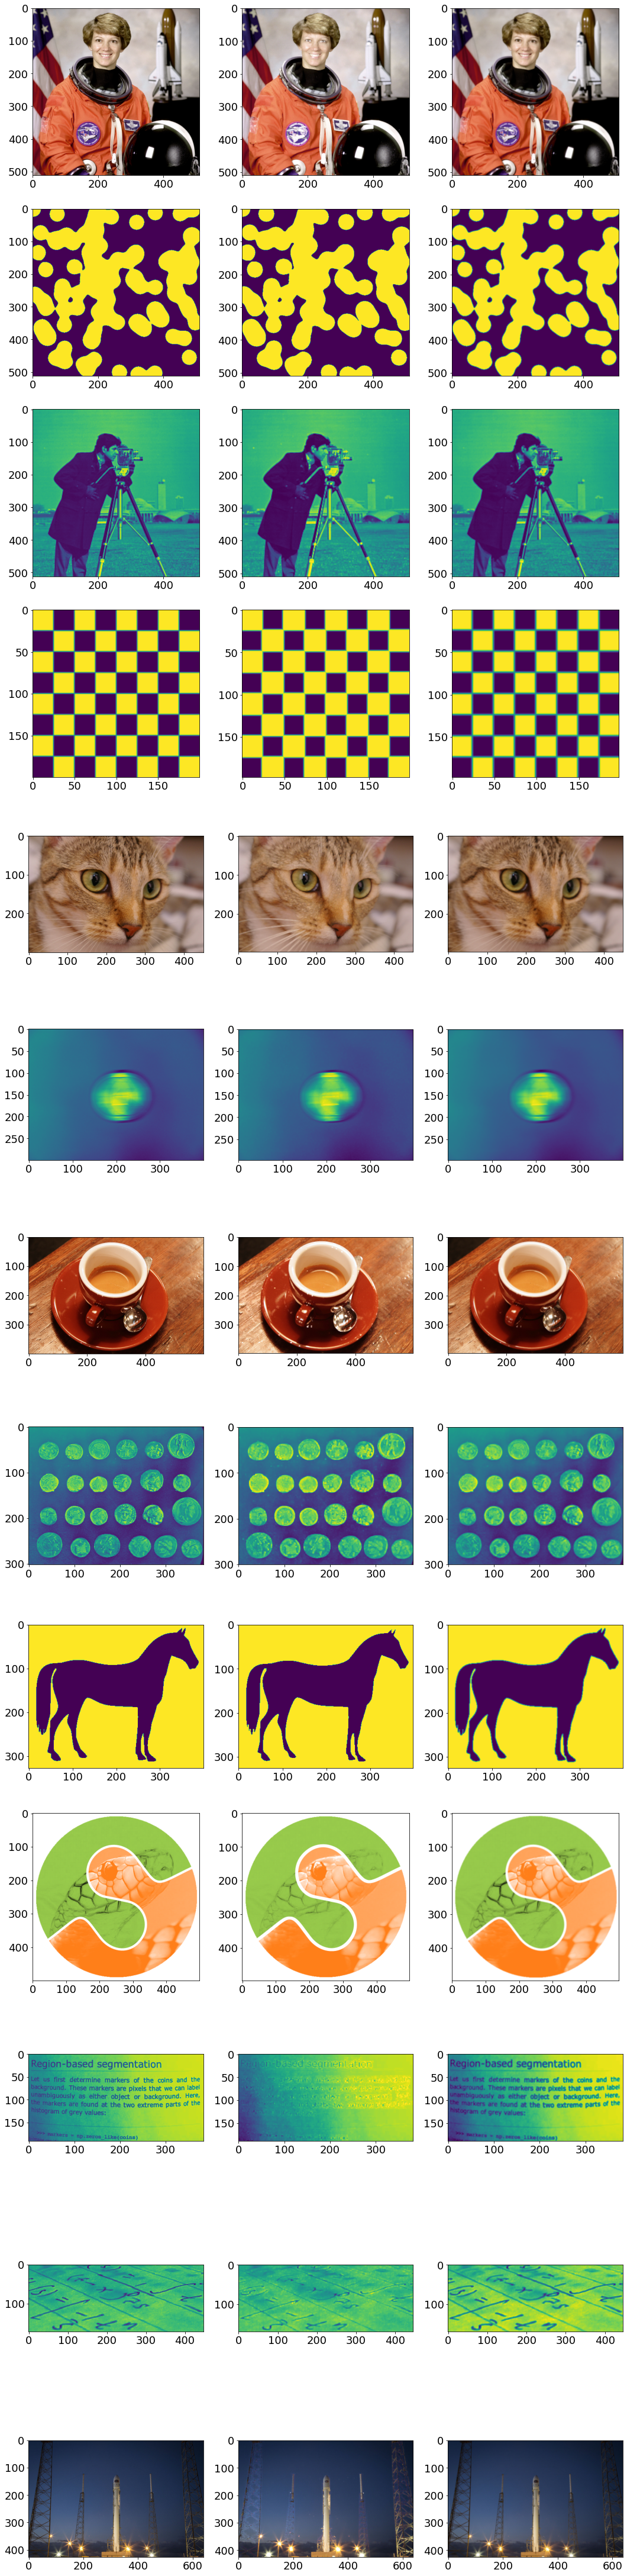

In [0]:
fig, axs = plt.subplots(nrows=len(images), ncols=3, figsize=(18,80))
i=0
for name in images:
  img = images[name]
  max_pool = torch.nn.MaxPool2d(3, stride=1)(img)
  avg_pool = torch.nn.AvgPool2d(3, stride=1)(img)
  if(img.shape[0] > 1):
    axs[i][0].imshow(img.T)
    axs[i][1].imshow(max_pool.T)
    axs[i][2].imshow(avg_pool.T)
  else:
    axs[i][0].imshow(img[0,:,:].T)
    axs[i][1].imshow(max_pool[0,:,:].T)
    axs[i][2].imshow(avg_pool[0,:,:].T)
  i += 1

## 2. CNN

In [0]:
training_data = datasets.FashionMNIST(".",download=True,train=True, transform=transforms.Compose([
                                                                                transforms.ToTensor()
]))
test_data = datasets.FashionMNIST(".",download=True,train=False, transform=transforms.Compose([
                                                                                transforms.ToTensor()
]))

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw
Processing...
Done!


In [0]:
print(training_data[0][0].shape)

torch.Size([1, 28, 28])


In [0]:
def train_epoch(net, opt, criterion, dataset = training_data, batch_size=50):
    net.train()
    losses = []
    trainloader = torch_data.DataLoader(dataset, batch_size=batch_size)
    for x_batch, y_batch in tqdm(trainloader):
        opt.zero_grad()
        # Forward
        y_comp = net(x_batch)
        # Compute diff
        loss = criterion(y_comp, y_batch)
        # Compute gradients
        loss.backward()
        # update weights
        opt.step()
        losses.append(loss.data.numpy())
    return losses

def accuracy(net, dataset = test_data):
  net.eval() # pass to model to evaluation mode
  correct = 0
  total = 0
  testloader = torch_data.DataLoader(dataset)
  for data in testloader:
      points, labels = data
      outputs = net(points)
      predicted = torch.round(outputs.data)
      total += labels.size(0)
      #print(predicted, labels, torch.argmax(predicted) == labels)
      correct += (torch.argmax(predicted) == labels).sum().item()
  net.train() # pass the model to training mode
  return correct / total


class ConvNet(torch.nn.Module):
  def __init__(self, kernel_size=5, depth = [1,4,8,16]):
    super(ConvNet, self).__init__()

    modules = []
    pad = (kernel_size-1) // 2
    for i in range(len(depth)-2):
      modules.append(nn.Conv2d(depth[i], depth[i+1], kernel_size=kernel_size, padding=pad))
      modules.append(nn.AvgPool2d(2, stride=2))
    modules.append(nn.Conv2d(depth[-2], depth[-1], kernel_size=kernel_size, padding=pad))

    self.conv = nn.Sequential(*modules)

    # self.conv = nn.Sequential(nn.Conv2d(1, 4, 5, padding=2),
    #                           nn.MaxPool2d(2, stride=2),
    #                           nn.Conv2d(4, 8, 5, padding=2),
    #                           nn.MaxPool2d(2, stride=2),
    #                           nn.Conv2d(8,16, 5, padding=2))
    nodes = np.power(28 // np.power(2, len(depth)-2), 2) * depth[-1]
    print(nodes)
    self.dense = nn.Sequential(nn.Linear(nodes, 128),
                               nn.ReLU(),
                               nn.Linear(128, 10),
                               nn.LogSoftmax(1))
    

  def forward(self, x):
    x = self.conv(x)
    #print(x.shape)
    x = x.view(x.shape[0], -1)
    #print(x.shape)
    x = self.dense(x)
    return x

784


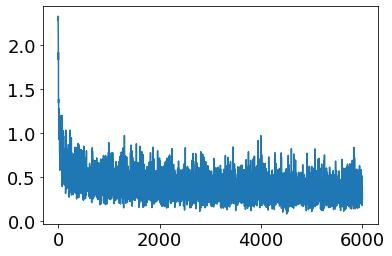

In [0]:
net = ConvNet()
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(net.parameters(),lr=5e-3,betas=(0.9, 0.999),eps=1e-08)
losses = []
for epoch in tqdm(range(5)):
  l = train_epoch(net, opt, criterion)
  losses += l

plt.plot(losses)

# Il y a (5x5x(1x4+4x8+8x16)) = 4100 paramètres dans ce le réseau de convolution et (784x128+128x10) = 101632 dans le réseau dense

In [0]:
print(accuracy(net, test_data))

0.8566


392


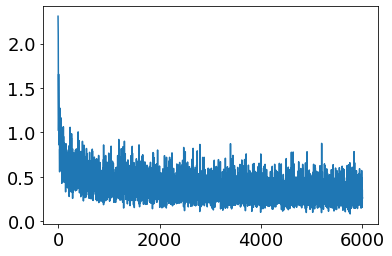

In [0]:
net2 = ConvNet(kernel_size = 5, depth = [1,2,4,8])
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(net2.parameters(),lr=5e-3,betas=(0.9, 0.999),eps=1e-08)
losses = []
for epoch in tqdm(range(5)):
  l = train_epoch(net2, opt, criterion)
  losses += l

plt.plot(losses)

In [0]:
print(accuracy(net2, test_data))

0.8509


392


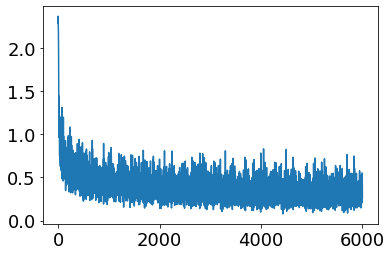

In [0]:
net3 = ConvNet(kernel_size = 3, depth = [1,2,4,8])
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(net3.parameters(),lr=5e-3,betas=(0.9, 0.999),eps=1e-08)
losses = []
for epoch in tqdm(range(5)):
  l = train_epoch(net3, opt, criterion)
  losses += l

plt.plot(losses)

In [0]:
print(accuracy(net3, test_data))

0.8587


3136


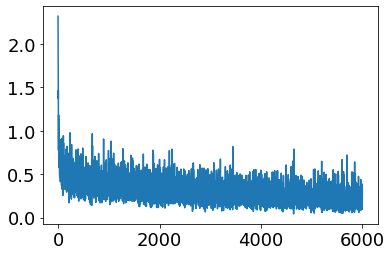

In [0]:
net4 = ConvNet(kernel_size = 3, depth = [1,4])
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(net4.parameters(),lr=5e-3,betas=(0.9, 0.999),eps=1e-08)
losses = []
for epoch in tqdm(range(5)):
  l = train_epoch(net4, opt, criterion)
  losses += l

plt.plot(losses)

#Il y a 3x3x(1x4) = 36 paramètres dens la partie de convolution, beaucoup moins que le premier réseau

In [0]:
print(accuracy(net4, test_data))

0.8608


## 3. Sharing parameters

In [0]:
import torchvision.models as models
import torchvision
# load pretrained model
alexnet = models.alexnet(pretrained=True)
# access weights from first layer
filter = alexnet.features[0].weight.data
# normalize to [0, 1]
filter = (1/(2*filter.max()))*filter + 0.5

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


In [0]:
filter.shape

torch.Size([64, 3, 11, 11])

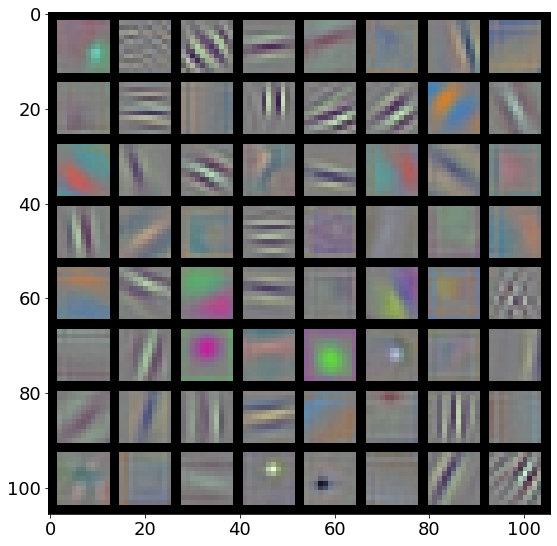

In [0]:
tmp = torchvision.utils.make_grid(filter)
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(tmp.T, interpolation='nearest')
plt.tight_layout()

# Le premier séries de filtres inclus plutôt des filtres de détection des patterns, des edges ou des taches


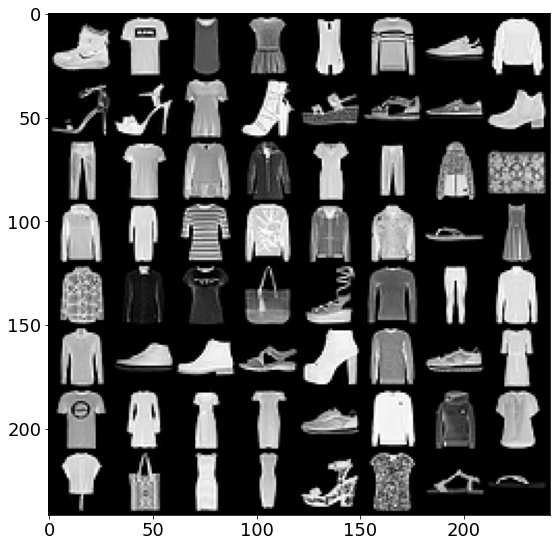

In [0]:
loader = torch_data.DataLoader(training_data, batch_size=64)
imgs, labels = iter(loader).next()
tmp = torchvision.utils.make_grid(imgs)
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(torch.transpose(tmp,0,2).transpose(0,1), cmap='hot')
plt.tight_layout()

## Final Model

In [0]:
def accuracy(net, dataset = test_data):
  net.eval() # pass to model to evaluation mode
  correct = 0
  total = 0
  testloader = torch_data.DataLoader(dataset)
  for data in testloader:
      points, labels = data
      points = points.cuda()
      labels = labels.cuda()
      outputs = net(points)
      predicted = torch.round(outputs.data)
      total += labels.size(0)
      #print(predicted, labels, torch.argmax(predicted) == labels)
      correct += (torch.argmax(predicted) == labels).sum().item()
  net.train() # pass the model to training mode
  return correct / total

def train_epoch(net, opt, criterion, dataset = training_data, batch_size=50):
    net.train()
    losses = []
    #valid_score = []
    trainloader = torch_data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    i = 0;
    for x_batch, y_batch in tqdm(trainloader):
        i += 1
        x_batch = x_batch.cuda()
        y_batch = y_batch.cuda()
        opt.zero_grad()
        # Forward
        y_comp = net(x_batch)
        # Compute diff
        loss = criterion(y_comp, y_batch)
        # Compute gradients
        loss.backward()
        # update weights
        opt.step()
        if(i%10 == 0):
          losses.append(loss.data)
          #valid_score.append(accuracy(net))
    return losses

In [0]:
class FullConvNet(torch.nn.Module):
  def __init__(self):
    super(FullConvNet, self).__init__()

    self.conv = nn.Sequential(nn.Conv2d(1, 64, 3, padding=2), #28
                              nn.ReLU(),
                              nn.BatchNorm2d(64),
                              nn.AvgPool2d(2,stride=2), #14
                              nn.Conv2d(64, 128, 3, padding=2), #14
                              nn.ReLU(),
                              nn.BatchNorm2d(128),
                              nn.AvgPool2d(2,stride=2), #7
                              nn.Conv2d(128, 256, 3, padding=2), #7
                              nn.ReLU(),
                              nn.BatchNorm2d(256)
                              )
    self.dense = nn.Sequential(nn.Linear(25600, 2048*2),
                              #  nn.ReLU(),
                              #  nn.BatchNorm1d(512),
                              #  nn.Linear(512, 128),
                              #  nn.ReLU(),
                              #  nn.BatchNorm1d(128),
                              #  nn.Linear(128, 64),
                              #  nn.ReLU(),
                              #  nn.BatchNorm1d(64),
                               nn.ReLU(),
                               nn.BatchNorm1d(2048*2),
                               nn.Linear(2048*2, 10),
                               nn.BatchNorm1d(10),
                               nn.LogSoftmax(1))
    

  def forward(self, x):
    x = self.conv(x)
    #print(x.shape)
    x = x.view(x.shape[0], -1)
    #print(x.shape)
    x = self.dense(x)
    return x

In [0]:
def init(m):
  if type(m) == nn.Linear:
    nn.init.kaiming_uniform_(m.weight)

model = FullConvNet()
model.cuda()
model.apply(init)
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(),lr=5e-3,betas=(0.9, 0.999),eps=1e-08)
losses = []
for epoch in tqdm(range(5)):
  l = train_epoch(model, opt, criterion)
  losses += l

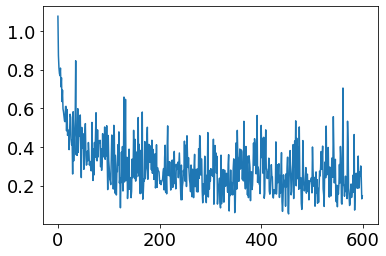

0.8704


In [0]:
plt.plot(losses, label='loss')
plt.show()
print(accuracy(model, test_data))


In [0]:
from google.colab import files
torch.save(model, 'model_thinh')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type FullConvNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
print(len(training_data[:][0]))